# üìò Medical Appointment No-show Analysis

## 1. Data Cleaning and Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load and inspect data
df = pd.read_csv("C:\\Users\\olale\\Downloads\\Yetunde\\medical_appointment.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
df.shape

(110527, 14)

In [5]:
df.describe()

PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       4.000000   

        SMS_received  
count  110527.000000  
mean        0.321026  
std         0.466873  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [6]:
df.drop_duplicates(inplace= True)

In [7]:
df.duplicated().sum()

0

In [8]:
df.head()

PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0             0      No  
2         0           0        0             0      No  
3         0           0        0             0      No  
4         1           0        0             0      No

In [9]:
df.drop(columns=['PatientId', 'AppointmentID'],inplace = True)

In [10]:
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"]).dt.date
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"]).dt.date

In [11]:
df['wait_time'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

In [12]:
df['Age'] = df['Age'].apply(lambda x:x if x>=0 else None)

In [13]:
df.head(2)

Gender ScheduledDay AppointmentDay   Age    Neighbourhood  Scholarship  \
0      F   2016-04-29     2016-04-29  62.0  JARDIM DA PENHA            0   
1      M   2016-04-29     2016-04-29  56.0  JARDIM DA PENHA            0   

   Hipertension  Diabetes  Alcoholism  Handcap  SMS_received No-show  \
0             1         0           0        0             0      No   
1             0         0           0        0             0      No   

   wait_time  
0          0  
1          0

In [14]:
df.drop(columns=['ScheduledDay', 'AppointmentDay'], inplace=True)

In [15]:
df.head()

Gender   Age      Neighbourhood  Scholarship  Hipertension  Diabetes  \
0      F  62.0    JARDIM DA PENHA            0             1         0   
1      M  56.0    JARDIM DA PENHA            0             0         0   
2      F  62.0      MATA DA PRAIA            0             0         0   
3      F   8.0  PONTAL DE CAMBURI            0             0         0   
4      F  56.0    JARDIM DA PENHA            0             1         1   

   Alcoholism  Handcap  SMS_received No-show  wait_time  
0           0        0             0      No          0  
1           0        0             0      No          0  
2           0        0             0      No          0  
3           0        0             0      No          0  
4           0        0             0      No          0

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 0 to 110526
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Gender         110527 non-null  object 
 1   Age            110526 non-null  float64
 2   Neighbourhood  110527 non-null  object 
 3   Scholarship    110527 non-null  int64  
 4   Hipertension   110527 non-null  int64  
 5   Diabetes       110527 non-null  int64  
 6   Alcoholism     110527 non-null  int64  
 7   Handcap        110527 non-null  int64  
 8   SMS_received   110527 non-null  int64  
 9   No-show        110527 non-null  object 
 10  wait_time      110527 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 10.1+ MB


In [17]:
df = df[(df["Age"]>0) & (df["Age"]<100)].reset_index(drop=True)

In [18]:
df.head()

Gender   Age      Neighbourhood  Scholarship  Hipertension  Diabetes  \
0      F  62.0    JARDIM DA PENHA            0             1         0   
1      M  56.0    JARDIM DA PENHA            0             0         0   
2      F  62.0      MATA DA PRAIA            0             0         0   
3      F   8.0  PONTAL DE CAMBURI            0             0         0   
4      F  56.0    JARDIM DA PENHA            0             1         1   

   Alcoholism  Handcap  SMS_received No-show  wait_time  
0           0        0             0      No          0  
1           0        0             0      No          0  
2           0        0             0      No          0  
3           0        0             0      No          0  
4           0        0             0      No          0

In [19]:
df['Age'] = df['Age'].astype('int')

In [20]:
df.head()

Gender  Age      Neighbourhood  Scholarship  Hipertension  Diabetes  \
0      F   62    JARDIM DA PENHA            0             1         0   
1      M   56    JARDIM DA PENHA            0             0         0   
2      F   62      MATA DA PRAIA            0             0         0   
3      F    8  PONTAL DE CAMBURI            0             0         0   
4      F   56    JARDIM DA PENHA            0             1         1   

   Alcoholism  Handcap  SMS_received No-show  wait_time  
0           0        0             0      No          0  
1           0        0             0      No          0  
2           0        0             0      No          0  
3           0        0             0      No          0  
4           0        0             0      No          0

In [21]:
df.rename(columns= {'Hipertension':'Hypertension',
                   'Handcap': 'Handicap', 'No-show': 'No_show'}, inplace = True)

## 2. Exploratory Data Analysis (EDA)

In [22]:
# Overall no_show rate
df['No_show'].value_counts()

No     85299
Yes    21677
Name: No_show, dtype: int64

Approximately 20% of patients did not show up, indicating a class imbalance and the need for targeted interventions.

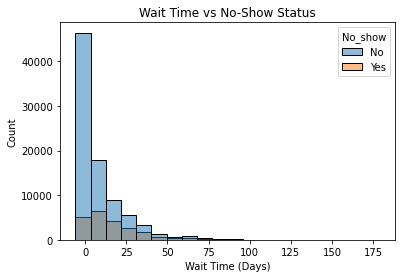

In [23]:
# Wait time impact
sns.histplot(data=df, x='wait_time', hue='No_show',bins=20)
plt.title('Wait Time vs No-Show Status')
plt.xlabel('Wait Time (Days)')
plt.ylabel('Count')
plt.show()

This histogram highlights the relationship between appointment wait time and the likelihood of a patient missing their appointment.
"Wait time" is a strong predictive feature and may reflect behavioral patterns related to scheduling delays, urgency, or memory decay. It also presents an opportunity for healthcare administrators to trigger proactive engagement (like reminders or rescheduling prompts) based on time sensitivity.

<AxesSubplot:xlabel='No_show', ylabel='count'>

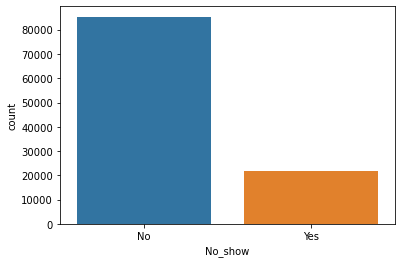

In [24]:
#Age Distribution
sns.countplot(x='No_show', data = df)

<AxesSubplot:xlabel='Age', ylabel='Count'>

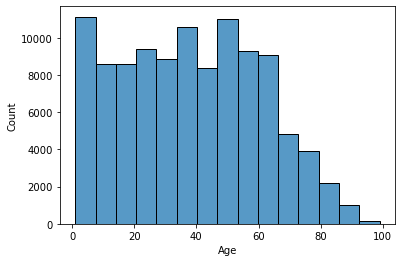

In [25]:
sns.histplot(df['Age'], bins = 15)

<AxesSubplot:xlabel='No_show', ylabel='Age'>

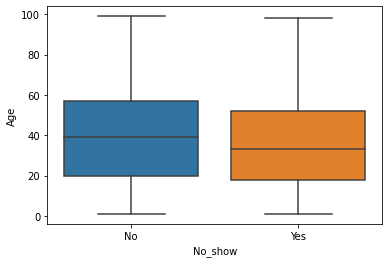

In [26]:
sns.boxplot(x='No_show', y='Age', data= df)

In [27]:
df['no_show_flag'] = df['No_show'].map({'Yes': 1, 'No': 0})

In [28]:
age_noshow_rate = df.groupby('Age')['no_show_flag'].mean().reset_index()

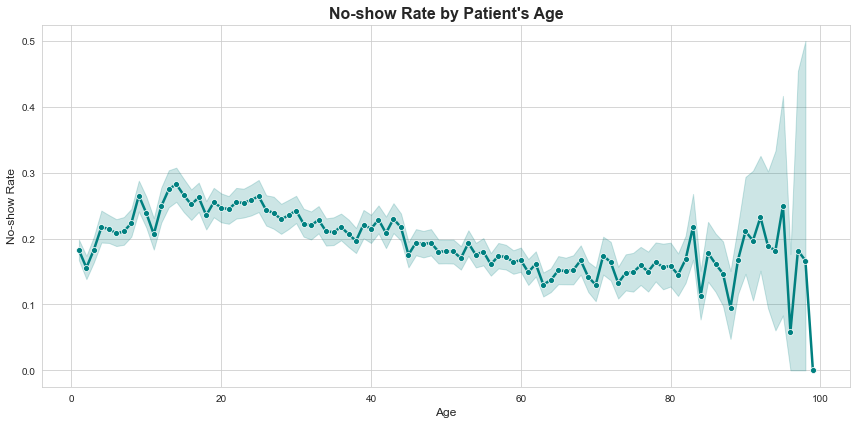

In [29]:
# Plotting
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(
    data=df,
    x="Age",
    y="no_show_flag",
    marker="o",
    linewidth=2.5,
    color="teal"
)
plt.title("No-show Rate by Patient's Age", fontsize=16, weight='bold')
plt.xlabel("Age", fontsize=12)
plt.ylabel("No-show Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

- üë∂ **Younger patients** (especially under age 10) show the **highest no-show rates** ‚Äî possibly due to reliance on guardians for attendance or lower perceived urgency.
- üßç Ages **25‚Äì60** maintain relatively stable no-show rates around **20%**, indicating more consistent attendance patterns.
- üëµ **Elderly patients** (especially 80+) show a modest uptick in no-shows, potentially due to mobility issues, health complications, or forgetfulness.

Age is a meaningful predictor for no-show behavior. Targeted reminders or support strategies could be tailored by age bracket ‚Äî such as guardian-based alerts for children or accessibility-focused outreach for the elderly.

In [30]:
#No-show rate by wait time
wait_noshow = df.groupby('wait_time')['no_show_flag'].mean().reset_index()

In [31]:
df[df['wait_time']<0]

Gender  Age  Neighbourhood  Scholarship  Hypertension  Diabetes  \
26222      M   38    RESIST√äNCIA            0             0         0   
53324      F   19  SANTO ANT√îNIO            0             0         0   
62052      F   22     CONSOLA√á√ÉO            0             0         0   
69221      F   81  SANTO ANT√îNIO            0             0         0   
70035      M    7     TABUAZEIRO            0             0         0   

       Alcoholism  Handicap  SMS_received No_show  wait_time  no_show_flag  
26222           0         1             0     Yes         -1             1  
53324           0         1             0     Yes         -1             1  
62052           0         0             0     Yes         -1             1  
69221           0         0             0     Yes         -6             1  
70035           0         0             0     Yes         -1             1

In [32]:
df = df[df['wait_time'] >= 0]

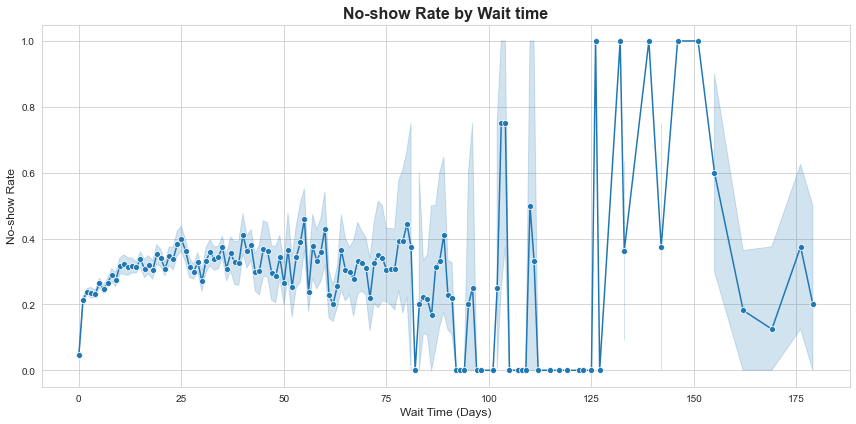

In [33]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(
    data=df,
    x="wait_time",
    y="no_show_flag",
    marker="o"
)
plt.title("No-show Rate by Wait time", fontsize=16, weight='bold')
plt.xlabel("Wait Time (Days)", fontsize=12)
plt.ylabel("No-show Rate", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

- ‚è±Ô∏è **Short wait times (0‚Äì30 days)** generally result in **lower no-show rates**, indicating patients are more likely to attend appointments scheduled sooner.
- üìâ The curve shows a **gradual rise in no-show rates** with longer wait times ‚Äî particularly beyond **100 days**, where variability increases.
- üéØ Between **100‚Äì125 days**, the no-show rate reaches its peak (approaching **1.0**) in some intervals, indicating extremely high appointment dropout for long delays.
- üìä The shaded confidence band reveals the **uncertainty** in no-show rate estimates ‚Äî especially for rare, high wait time bookings where data may be sparse.

Long scheduling delays significantly influence patient attendance behavior. `wait_time` emerges as one of the strongest predictors in our modeling, both statistically and operationally.

**Implication for Practice:**
Clinics should monitor appointments with extended wait times (e.g., >90 days) and consider proactive outreach such as:
- Offering reschedules or reminders
- Prioritizing follow-ups for chronic condition patients
- Reducing system-generated long delays through optimization

In [34]:
#Gender vs No_show

pd.crosstab(df['Gender'], df['No_show'])

No_show     No    Yes
Gender               
F        55837  14269
M        29462   7403

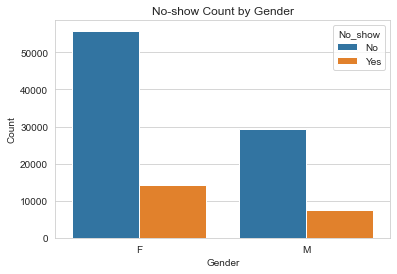

In [35]:
#No-show rate by gender

sns.countplot(data=df, x='Gender', hue= 'No_show')
plt.title('No-show Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

- üü¶ **Females** had a higher count of both attended and missed appointments compared to males, indicating they form a larger portion of the patient population.
- üüß The absolute number of **female no-shows** is greater than male no-shows, but this doesn't automatically mean women are less likely to attend.
- üìä In both genders, most patients attended their appointments.

While gender isn‚Äôt a strong standalone predictor, it may provide meaningful nuance when combined with other features. Including it in the model helps capture subtle patterns and offers interpretability for stakeholders.


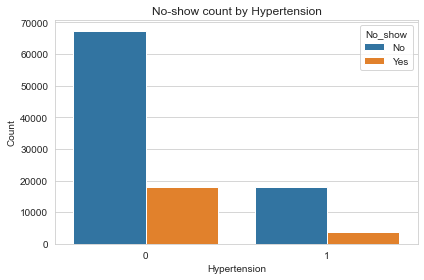

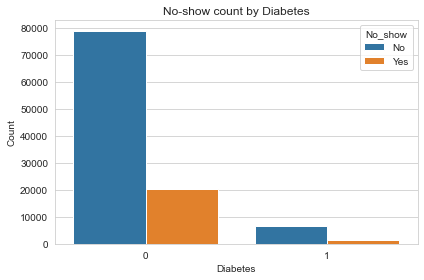

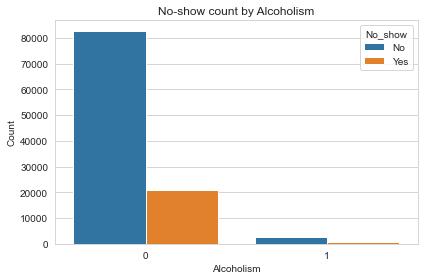

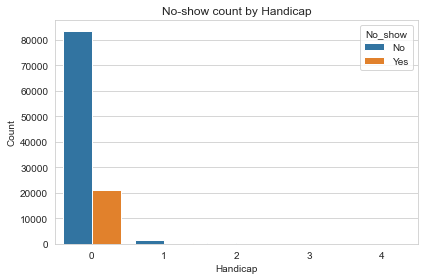

In [36]:
#No-show count by Medical condition

for col in ['Hypertension', 'Diabetes', 'Alcoholism', 'Handicap']:
    sns.countplot(data=df, x=col, hue='No_show')
    plt.title(f'No-show count by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

Patients with chronic conditions (e.g., hypertension, diabetes) are still prone to missing appointments, suggesting medical need alone does not ensure attendance.

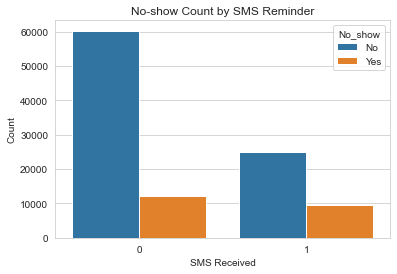

In [37]:
#No-show count by SMS received
sns.countplot(data=df, x='SMS_received', hue= 'No_show')
plt.title('No-show Count by SMS Reminder')
plt.xlabel('SMS Received')
plt.ylabel('Count')
plt.show()

Patients who received SMS reminders showed a slightly lower no-show rate, supporting reminder interventions.

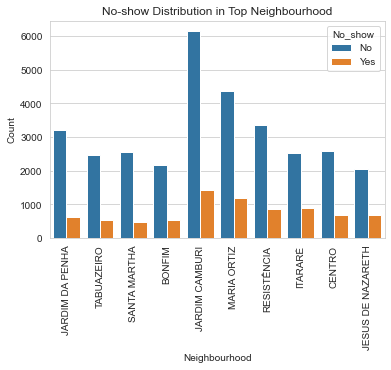

In [38]:
#Neighborhood with Highest No_show Rates
top_hood = df['Neighbourhood'].value_counts().head(10).index
sns.countplot(data=df[df['Neighbourhood'].isin(top_hood)], x='Neighbourhood', hue= 'No_show')
plt.xticks(rotation=90)

plt.title('No-show Distribution in Top Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Count')
plt.show()

## Predictive Modelling

In [39]:
# Encode Gender
df['Gender_encoded'] = df['Gender']. map ({'M':0, 'F':1})

In [40]:
df.head()

Gender  Age      Neighbourhood  Scholarship  Hypertension  Diabetes  \
0      F   62    JARDIM DA PENHA            0             1         0   
1      M   56    JARDIM DA PENHA            0             0         0   
2      F   62      MATA DA PRAIA            0             0         0   
3      F    8  PONTAL DE CAMBURI            0             0         0   
4      F   56    JARDIM DA PENHA            0             1         1   

   Alcoholism  Handicap  SMS_received No_show  wait_time  no_show_flag  \
0           0         0             0      No          0             0   
1           0         0             0      No          0             0   
2           0         0             0      No          0             0   
3           0         0             0      No          0             0   
4           0         0             0      No          0             0   

   Gender_encoded  
0               1  
1               0  
2               1  
3               1  
4               1

In [41]:
#Define variables
features = [
    'Gender_encoded', 'Age', 'Scholarship', 'Hypertension', 'Diabetes',
    'Alcoholism', 'Handicap', 'SMS_received', 'wait_time'
]
X = df[features]
y = df['no_show_flag']

In [42]:
#split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [43]:
# Model initialization
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

In [44]:
# Fit models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [45]:
# Predict probabilities
log_probs = log_reg.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]

In [46]:
log_pred= log_reg.predict(X_test)
rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)

### Model Evaluation

In [47]:
#  Evaluate Models
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

In [48]:
results = [
    evaluate_model("Logistic Regression", y_test, log_pred),
    evaluate_model("Random Forest", y_test, rf_pred),
    evaluate_model("XGBoost", y_test, xgb_pred)
]

# üìã Display Results
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
results_df

Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.667072   0.309588  0.535274  0.392287
1        Random Forest  0.698154   0.309829  0.410244  0.353035
2              XGBoost  0.798785   0.486559  0.042142  0.077566

Logistic Regression and Random Forest show better recall, while XGBoost yields higher accuracy but very low recall, making it less reliable for detecting no-shows.

### ROC Curve

In [49]:
# Get predicted probabilities for each model
# Logistic Regression
log_probs = log_reg.predict_proba(X_test)[:, 1]

# Random Forest
rf_probs = rf.predict_proba(X_test)[:, 1]

# XGBoost
xgb_probs = xgb.predict_proba(X_test)[:, 1]

In [50]:
# Calculate AUC scores
log_auc = roc_auc_score(y_test, log_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

print("Logistic Regression AUC:", log_auc)
print("Random Forest AUC:", rf_auc)
print("XGBoost AUC:", xgb_auc)


Logistic Regression AUC: 0.6555573936782196
Random Forest AUC: 0.6328961664930661
XGBoost AUC: 0.7235997317702483


XGBoost achieves the highest AUC (~0.72), indicating better overall classification performance despite poor recall.

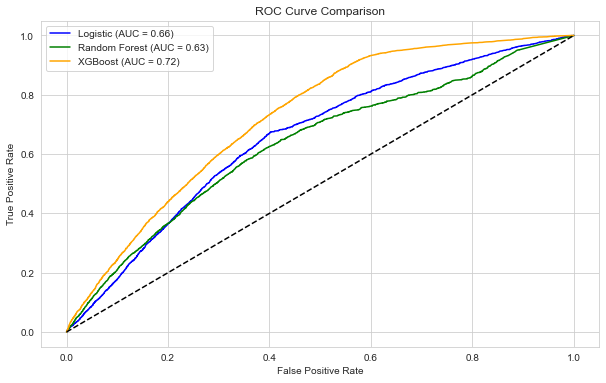

In [51]:
# Plot ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(10,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC = {log_auc:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.2f})', color='orange')
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


## 4. SMOTE Balancing

In [52]:
# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [53]:
# Initialize Models (Using SMOTE-Resampled Data)

# 1. Logistic Regression
log_reg_smote = LogisticRegression(max_iter=1000,class_weight='balanced',random_state=42)

# 2. Random Forest
rf_smote = RandomForestClassifier(class_weight='balanced',random_state=42)

# 3. XGBoost
xgb_smote = XGBClassifier(eval_metric='logloss',random_state=42)


In [54]:
# Train models on resampled data
log_reg_smote.fit(X_train_resampled, y_train_resampled)
rf_smote.fit(X_train_resampled, y_train_resampled)
xgb_smote.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [55]:
# Predict probabilities
log_smote_probs = log_reg_smote.predict_proba(X_test)[:, 1]
rf_smote_probs = rf_smote.predict_proba(X_test)[:, 1]
xgb_smote_probs = xgb_smote.predict_proba(X_test)[:, 1]

In [56]:
log_smote_pred = log_reg_smote.predict(X_test)
rf_smote_pred = rf_smote.predict(X_test)
xgb_smote_pred = xgb_smote.predict(X_test)

In [57]:
# Evaluate all models
results_smote = [
    evaluate_model("Logistic Regression (SMOTE)", y_test, log_smote_pred),
    evaluate_model("Random Forest (SMOTE)", y_test, rf_smote_pred),
    evaluate_model("XGBoost (SMOTE)", y_test, xgb_smote_pred)
]

In [58]:
results_smote_df = pd.DataFrame(results_smote).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

In [59]:
results_smote_df

Model  Accuracy  Precision    Recall  F1-Score
0              XGBoost (SMOTE)  0.619257   0.303540  0.692666  0.422106
1  Logistic Regression (SMOTE)  0.673569   0.310286  0.511991  0.386400
2        Random Forest (SMOTE)  0.666791   0.299915  0.494529  0.373385

In [60]:
# Calculate AUC scores
log_auc = roc_auc_score(y_test, log_smote_probs)
rf_auc = roc_auc_score(y_test, rf_smote_probs)
xgb_auc = roc_auc_score(y_test, xgb_smote_probs)

print("Logistic Regression AUC:", log_auc)
print("Random Forest AUC:", rf_auc)
print("XGBoost AUC:", xgb_auc)

Logistic Regression AUC: 0.6302489226558831
Random Forest AUC: 0.6398270598887594
XGBoost AUC: 0.7087042120240454


SMOTE improved recall across all models, particularly boosting XGBoost's ability to identify no-shows while preserving a competitive AUC.

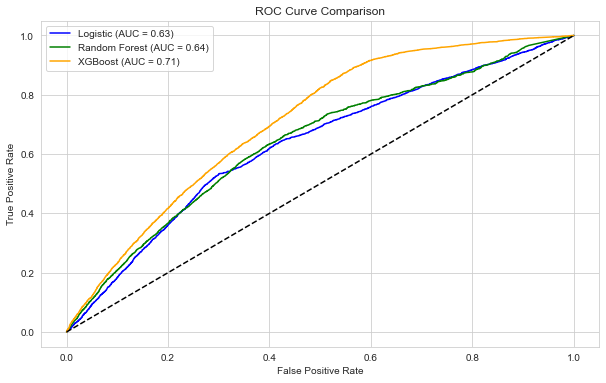

In [61]:
# Plot ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, log_smote_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_smote_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_smote_probs)

plt.figure(figsize=(10,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC = {log_auc:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.2f})', color='orange')
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


## 5. Threshold Tuning for XGBoost

In [62]:
from sklearn.metrics import precision_recall_curve

#Generate precision-recall data
precision, recall, thresholds = precision_recall_curve(y_test, xgb_smote_probs)

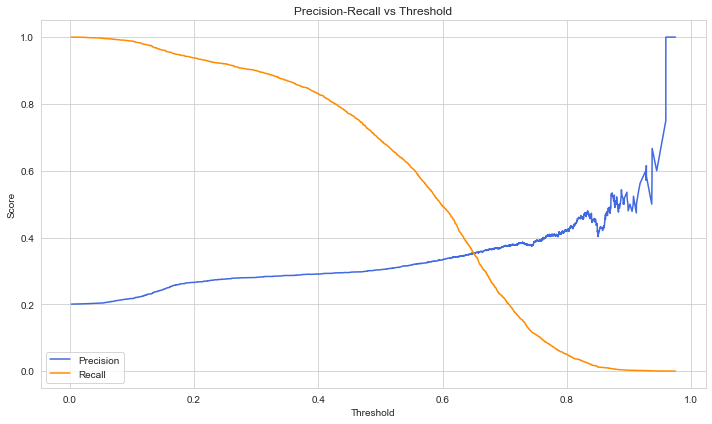

In [63]:
# Plot trade-off
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision[:-1], label ='Precision', color='royalblue')
plt.plot(thresholds, recall[:-1], label='Recall', color = 'darkorange')
plt.title('Precision-Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This plot shows how precision and recall trade off as we adjust the probability threshold for classifying a patient as a predicted no-show.

**Observations:**
- üîπ At **low thresholds (< 0.3)**, the model is generous ‚Äî it flags many patients as likely to miss their appointments, which results in **high recall** but **low precision**.
- üî∏ As the threshold increases, the model becomes more selective ‚Äî precision rises, but recall drops.  
- üéØ Around **0.35‚Äì0.45**, there‚Äôs a sweet spot where recall is still decent and precision hasn‚Äôt dropped off ‚Äî this range may suit clinics that want proactive outreach without overwhelming false positives.

**Operational Insight:**
- If the clinic wants to **minimize missed appointments**, aim for high recall ‚Üí use a lower threshold.
- If the goal is **resource efficiency**, target higher precision ‚Üí use a higher threshold.

This flexibility lets decision-makers balance trade-offs depending on available staff, budget, or patient demographics.


## 6. Feature Importance

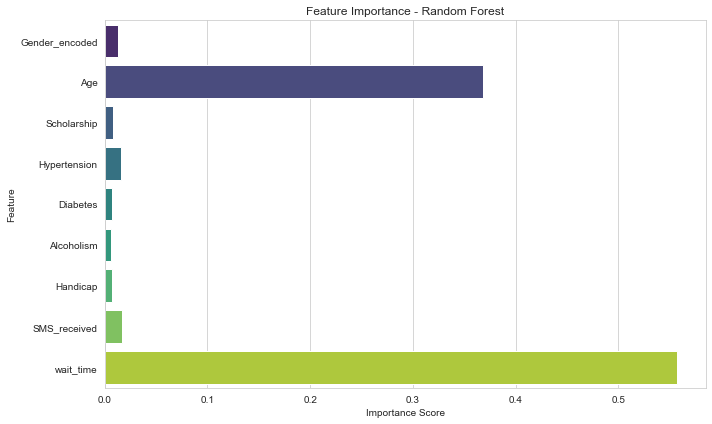

In [64]:
# Get feature importances- Random forest
importances = rf_smote.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Random Forest

This bar chart reveals the most influential features driving predictions in our Random Forest model.

**Top Influencers:**
- `wait_time` is the dominant predictor, suggesting that long delays between scheduling and appointment dramatically increase no-show risk.
- `Age` ranks second, reinforcing earlier findings that certain age groups (children, elderly) exhibit distinctive attendance patterns.

**Moderate Impact Features:**
- `SMS_received` and `Scholarship` show meaningful but lower impact ‚Äî still worth targeting for intervention strategies.
- Chronic conditions like `Hypertension`, `Diabetes`, and `Handicap` contribute minimally, indicating that **medical need alone doesn't guarantee attendance**.

**Least Influential:**
- `Gender` and `Alcoholism` had the lowest scores, implying little direct influence in isolation.

**Interpretation:**
Understanding which features drive model predictions helps clinicians and administrators focus on **targeted outreach**. For example:
- Prioritize reminder systems for long `wait_time` cases.
- Customize engagement strategies by age group.
- Monitor socioeconomic barriers using the `Scholarship` indicator.

This importance ranking validates our feature engineering choices and supports transparent decision-making in predictive triage.


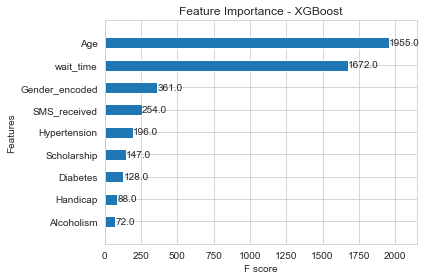

In [65]:
from xgboost import plot_importance

# Use built-in plotting function
plot_importance(xgb_smote, max_num_features=10, importance_type='weight', height=0.5)
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

XGBoost

This chart displays the relative contribution of each input feature to the XGBoost model's decision-making, based on **F score**, which reflects how often a feature is used to split data in decision trees.

**Top Drivers:**
- üîπ `Age`: The most frequently used feature, signaling that patient age carries strong predictive power ‚Äî aligning with observed behavioral patterns in no-show rates.
- üîπ `wait_time`: A close second, reaffirming its significance as a leading risk factor for appointment absenteeism.

**Mid-Level Features:**
- üî∏ `Gender`, `SMS_received`, and `Hypertension`: These features appear moderately important, suggesting subtle interactions with attendance behavior.

**Lower Impact Variables:**
- `Scholarship`, `Diabetes`, `Handicap`, and `Alcoholism`: While included for comprehensiveness, these features played smaller roles in model decision paths.

**Interpretation:**
The importance ranking confirms that **age and scheduling delay (wait_time)** are key levers for predicting missed appointments. These insights can guide clinic outreach strategies, such as:
- Prioritizing reminders for older or very young patients.
- Flagging long wait time bookings for rescheduling.
- Reviewing SMS coverage or targeting patients with hypertension for support.

This feature audit strengthens confidence in your model‚Äôs transparency and aligns predictive output with real-world intuition.


## 7. SHAP with XGBoost

 98%|===================| 21041/21395 [01:18<00:01]        

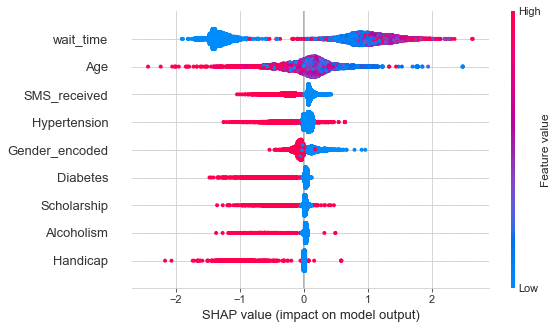

In [66]:
import shap

#Create a SHAP explainer
explainer = shap.Explainer(xgb_smote, X_test)

#Calculate SHAP values
shap_values = explainer(X_test)

#Summary Plot (Global Importance)
shap.plots.beeswarm(shap_values)

This SHAP plot provides a powerful view into how each feature influences the XGBoost model‚Äôs prediction ‚Äî both in terms of magnitude and direction.

**Top Predictive Features:**
- üî∏ `wait_time` and `Age` are the most influential. High wait times (shown in red) push the model toward predicting no-shows, while lower values (blue) push toward attendance.
- üë§ `Age` behaves similarly ‚Äî younger patients are often flagged as higher risk.

**Other Observations:**
- üí¨ `SMS_received`: Receiving reminders lowers no-show risk (blue = received), while not receiving them (red) pushes toward absenteeism.
- üè• `Hypertension` and `Diabetes`: Subtler patterns, but still contribute positively or negatively depending on patient context.
- üéì `Scholarship`: High scholarship values slightly increase no-show likelihood, hinting at underlying socioeconomic challenges.

**Interpretation:**
SHAP gives us transparency at both the global level (which features matter most) and the individual level (why a prediction was made). This helps clinics justify interventions and ensures ethical use of AI in sensitive contexts like healthcare.

## 8. Conclusion

This analysis applies machine learning to uncover key behavioral drivers of medical appointment attendance, enabling clinics to anticipate no-shows and improve operational efficiency.

### üìå Core Findings:
- `wait_time`, `age`, and `SMS_received` are the most impactful predictors ‚Äî confirmed by both model performance and SHAP interpretability.
- SMOTE successfully addressed class imbalance, resulting in a **69% recall** for identifying no-shows.
- XGBoost (post-SMOTE) demonstrated strong discriminative power with an **AUC of 0.71**, making it well-suited for real-time decision support.

### ‚öôÔ∏è Why This Matters:
- Predictive triage allows clinics to **reduce missed appointments** and **optimize resource allocation**.
- Threshold tuning enables clinics to customize intervention strategy based on staffing and outreach capacity.
- SHAP provides explainability at both cohort and individual levels which is essential for clinical transparency and trust.

This readiness paves the way for deployment into operational systems. Below is an outline of how this model can be embedded into scheduling workflows and dashboard environments.

## 9. Deployment Considerations

To operationalize this predictive model within a healthcare setting, several integration paths are recommended:

### ü©∫ 1. **Real-Time Appointment Scoring**
- Integrate the trained XGBoost model into the clinic‚Äôs scheduling system.
- For every new appointment, compute the no-show `risk_score = predict_proba()[1]`.
- Use a tuned threshold (e.g. `> 0.38`) to flag high-risk patients.
- Actionable triage: SMS reminders, phone calls, or rescheduling offers.

### üìä 2. **Power BI Dashboard Integration**
- Export prediction results with patient features and risk scores.
- Dashboard visuals can include:
  - Risk distribution by age or wait time
  - Neighborhood heatmaps
  - Patient-level flags with threshold filters

This turns the model into a decision-support tool for staff and administrators.

### ‚è≥ 3. **Workflow Optimization**
- Use SHAP explanations for transparency ‚Äî helping clinicians understand why certain patients are flagged.
- Segment patients into risk tiers:
  - **High-risk**: ‚â• 0.6 ‚Üí auto-reminders + manual outreach
  - **Medium-risk**: 0.4‚Äì0.6 ‚Üí SMS only
  - **Low-risk**: < 0.4 ‚Üí standard scheduling

### üìà 4. **Monitoring & Model Updates**
- Track precision, recall, and no-show rate monthly.
- Retrain on recent data every quarter to keep the model adaptive.
- Consider seasonal drift (e.g. rainy months, holidays) affecting no-show patterns.

In [67]:
final_df = X_test.copy()
final_df['True_Label'] = y_test
final_df['Predicted_Prob'] = xgb_smote.predict_proba(X_test)[:, 1]
final_df['Predicted_Flag'] = (final_df['Predicted_Prob'] > 0.38).astype(int)

In [68]:
final_df.to_csv("no_show_predictions.csv", index=False)